<a href="https://colab.research.google.com/github/dtabuena/Patch_Ephys/blob/main/Refactor/Analyze_Recs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import pyabf
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
import urllib.request
import sklearn as skl
import sklearn.mixture as skl_mixture
import seaborn as sns
# warnings.filterwarnings('ignore')
# np.set_printoptions(threshold=sys.maxsize)
# clear_output(wait=False)


!pip install openpyxl
!pip install XlsxWriter

In [9]:
'''Get Repositories'''
"run dtabuena's ephys notebooks"
to_import = [
            # 'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            # 'Simple_ABF_tools.ipynb',
            # 'fun_math.ipynb',
            # 'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'input_resistance_analyzer.ipynb',
            'gain_analyzer.ipynb',
            'latencey_analyzer.ipynb',
            'IV_analyzer.ipynb',
            'Vm_analyzer.ipynb',
            'membrane_analyzer.ipynb',
            'Ephys_wrapper.ipynb',
            'rheobase_analyzer.ipynb',
            'init_func_arg_dicts.ipynb',
            ]



parent_folder = r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor"
os.chdir(parent_folder)

code_dir = 'git_code'
os.makedirs(code_dir,exist_ok=True)
os.chdir(code_dir)

for f in to_import:
    try:
        git_link = 'https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/'+f
        # print(git_link)
        urllib.request.urlretrieve(git_link,f)
        %run $f
        print('loaded:',f)
    except:
        print('FAILED:',f)


# import urllib
# response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
# %run Load_FS6.py

loaded: Basic_Ephys.ipynb
loaded: QC_recoding_dataframe.ipynb
loaded: input_resistance_analyzer.ipynb
loaded: gain_analyzer.ipynb
loaded: latencey_analyzer.ipynb
loaded: IV_analyzer.ipynb
loaded: Vm_analyzer.ipynb
loaded: membrane_analyzer.ipynb
loaded: Ephys_wrapper.ipynb
loaded: rheobase_analyzer.ipynb
loaded: init_func_arg_dicts.ipynb


In [15]:
def init_func_arg_dicts():
    func_dict = {}
    arg_dict = {}

    # Spike arg defentitions
    spike_args_gain={'spike_thresh':10, 'high_dv_thresh': 20,'low_dv_thresh': -5,'window_ms': 3}
    spike_args_rheo ={'spike_thresh':15, 'high_dv_thresh': 30,'low_dv_thresh': -15,'window_ms': 2}



    func_dict['VC - 3min GapFree']= rmp_analyzer
    arg_dict['VC - 3min GapFree'] = [True] # [to_plot?]

    func_dict['I0 - 3min GapFree']= rmp_analyzer
    arg_dict['I0 - 3min GapFree'] = [True] # [to_plot?]

    func_dict['IC - Rheobase']= rheobase_analyzer
    arg_dict['IC - Rheobase'] = [spike_args_rheo, True, False, False]  # [spike_args, to_plot, verbose, force_singlespike]

    func_dict['IC - Gain - D10pA']= gain_analyzer
    arg_dict['IC - Gain - D10pA']= [spike_args_gain, 1, 4, .7,[-60,-80]]  # [spike_args, to_plot [0:2], max_fit_steps, rel_slope_cut, Vh_hilo]

    func_dict['IC - Gain - D20pA']= gain_analyzer
    arg_dict['IC - Gain - D20pA']= [spike_args_gain, 1, 4, .7,[-60,-80]]  # [spike_args, to_plot [0:2], max_fit_steps, rel_slope_cut, Vh_hilo]

    func_dict['IC - Gain - D25pA']= gain_analyzer
    arg_dict['IC - Gain - D25pA']= [spike_args_gain, 1, 4, .7,[-60,-80]]  # [spike_args, to_plot [0:2], max_fit_steps, rel_slope_cut, Vh_hilo]

    func_dict['IC - Gain - D50pA']= func_dict['IC - Gain - D20pA']
    arg_dict['IC - Gain - D50pA']= arg_dict['IC - Gain - D20pA']

    func_dict['VC - MemTest-10ms-160ms']= membrane_analyzer
    arg_dict['VC - MemTest-10ms-160ms']= [True, False, ['Ra', 'Rm', 'Cm', 'tau',	'Cmq',	'Cmf',	'Cmqf', 'Cm_pc']]  # [to_plot, verbose]

    func_dict['IC - Latentcy 800pA-1s']= latencey_analyzer
    arg_dict['IC - Latentcy 800pA-1s']= [spike_args_gain, True]  # [spike_args, to_plot]

    func_dict['IC - R input']= input_resistance_analyzer
    arg_dict['IC - R input']= [[-30, 10] ,True]  # [dVm_limits, to_plot]

    func_dict['VC - Multi IV - 150ms'] = IV_analyzer_v2
    arg_dict['VC - Multi IV - 150ms']= [{'IV_Early':(4.5, 30),'IV_Steady_State':(70,80)} ,[False, True]]  # [measure_windows, to_plot]

    return func_dict, arg_dict

In [16]:
##### Setup Protocol List
VC_prot = ['VC - MemTest-10ms-160ms',
           'VC - Multi IV - 150ms',]
IC_prot = ['IC - Gain - D10pA',
           'IC - Gain - D20pA',
           'IC - Gain - D50pA',
           'IC - Rheobase',
           'IC - R input',
           'IC - Latentcy 800pA-1s'
           'VC - 3min GapFree',
           'I0 - 3min GapFree']


dataset = {'data_name': 'test_data',
           'data_source': r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data",
           'file_naming_scheme': ['Rec_date','geno','sex','age','orientation','slice','cell','type'],
           }

analysis_dir =os.path.join(parent_folder,dataset['data_name'])
os.makedirs(analysis_dir,exist_ok=True)
os.chdir(analysis_dir)
print(os.getcwd())


C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data


In [8]:
"""
New function to analyze using itterator.
BUT store results from each protocol in different dict
"""

'\nNew function to analyze using itterator.\nBUT store results from each protocol in different dict\n'

In [ ]:
abf_recordings_df

,Recording_name,cell_id,Rec_date,geno,sex,age,orientation,slice,cell,type,...,Cm_pc_160.0,Rmp_mV,IV_Early,IV_Steady_State,is_compensated,sum_delta,Spike_latency_(ms),Ramp_AP_thresh,Ramp_Vh,Ramp_Rheobase
file_name,,,,,,,,,,,,,,,,,,,,,
C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0000.abf,2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0000...,2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC,2024x04x24,E3KI,F,P598,sagi,s001,c001,DGC,...,59.132035,None,None,None,None,None,None,None,None,None
C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0001.abf,2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0001...,2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC,2024x04x24,E3KI,F,P598,sagi,s001,c001,DGC,...,None,-28.073755,None,None,None,None,None,None,None,None
C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0002.abf,2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0002...,2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC,2024x04x24,E3KI,F,P598,sagi,s001,c001,DGC,...,None,None,None,None,None,None,None,None,None,None


,Recording_name,Rec_date,geno,sex,age,orientation,slice,cell,type,protocol,...,Cm_pc_160.0,Rmp_mV,IV_Early,IV_Steady_State,is_compensated,sum_delta,Spike_latency_(ms),Ramp_AP_thresh,Ramp_Vh,Ramp_Rheobase
2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC,[2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_000...,"[2024x04x24, 2024x04x24, 2024x04x24, 2024x04x2...","[E3KI, E3KI, E3KI, E3KI, E3KI, E3KI, E3KI, E3K...","[F, F, F, F, F, F, F, F, F, F, F, F]","[P598, P598, P598, P598, P598, P598, P598, P59...","[sagi, sagi, sagi, sagi, sagi, sagi, sagi, sag...","[s001, s001, s001, s001, s001, s001, s001, s00...","[c001, c001, c001, c001, c001, c001, c001, c00...","[DGC, DGC, DGC, DGC, DGC, DGC, DGC, DGC, DGC, ...","[VC - MemTest-10ms-160ms, I0 - 3min GapFree, V...",...,"[59.132035142652065, None, None, None, None, N...","[None, -28.073755, None, None, None, None, Non...","[None, None, None, {'range': (4.5, 30), 'I_pea...","[None, None, None, {'range': (70, 80), 'I_peak...","[None, None, None, True, True, True, None, Non...","[None, None, None, 60.992431640625, 60.9924316...","[None, None, None, None, None, None, 57.0, 57....","[None, None, None, None, None, None, -39.85595...","[None, None, None, None, None, None, -70.8602,...","[None, None, None, None, None, None, 45.684568..."
2024x04x24_E3KI_F_P598_sagi_s001_c002_DGC,[2024x04x24_E3KI_F_P598_sagi_s001_c002_DGC_000...,"[2024x04x24, 2024x04x24, 2024x04x24, 2024x04x2...","[E3KI, E3KI, E3KI, E3KI, E3KI, E3KI, E3KI, E3KI]","[F, F, F, F, F, F, F, F]","[P598, P598, P598, P598, P598, P598, P598, P598]","[sagi, sagi, sagi, sagi, sagi, sagi, sagi, sagi]","[s001, s001, s001, s001, s001, s001, s001, s001]","[c002, c002, c002, c002, c002, c002, c002, c002]","[DGC, DGC, DGC, DGC, DGC, DGC, DGC, DGC]","[VC - MemTest-10ms-160ms, VC - MemTest-10ms-16...",...,"[50.57570438477137, -7847.893213656604, None, ...","[None, None, None, None, None, None, None, None]","[None, None, {'range': (4.5, 30), 'I_peak': [-...","[None, None, {'range': (70, 80), 'I_peak': [-1...","[None, None, True, True, True, None, None, None]","[None, None, 60.90087890625, 60.90087890625, 6...","[None, None, None, None, None, 105.30000000000...","[None, None, None, None, None, -20.599365, -20...","[None, None, None, None, None, -70.633415, -70...","[None, None, None, None, None, 84.328432843284..."
2024x04x24_E3KI_F_P598_sagi_s002_c003_DGC,[2024x04x24_E3KI_F_P598_sagi_s002_c003_DGC_000...,"[2024x04x24, 2024x04x24, 2024x04x24, 2024x04x2...","[E3KI, E3KI, E3KI, E3KI, E3KI, E3KI, E3KI, E3K...","[F, F, F, F, F, F, F, F, F, F]","[P598, P598, P598, P598, P598, P598, P598, P59...","[sagi, sagi, sagi, sagi, sagi, sagi, sagi, sag...","[s002, s002, s002, s002, s002, s002, s002, s00...","[c003, c003, c003, c003, c003, c003, c003, c00...","[DGC, DGC, DGC, DGC, DGC, DGC, DGC, DGC, DGC, ...","[VC - MemTest-10ms-160ms, I0 - 3min GapFree, V...",...,"[29.637778305089338, None, None, None, None, N...","[None, -71.70447, None, None, None, None, None...","[None, None, {'range': (4.5, 30), 'I_peak': [-...","[None, None, {'range': (70, 80), 'I_peak': [-1...","[None, None, True, True, True, True, None, Non...","[None, None, 60.814208984375, 60.814208984375,...","[None, None, None, None, None, None, 62.400000...","[None, None, None, None, None, None, -36.2854,...","[None, None, None, None, None, None, -71.6151,...","[None, None, None, None, None, None, 50.005000..."


<Figure size 640x480 with 0 Axes>

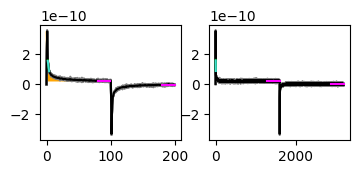

In [17]:
"""
Scripted Run
(unwraped 'ephys wrapper')
"""
# init Output
results = {}


'''Build Basic DF'''
abf_recordings_df, protocol_set = catalogue_recs(dataset['data_source'],dataset['file_naming_scheme'])
results['abf_recordings_df'] = abf_recordings_df
results['protocol_set'] = protocol_set

'''# Protocol Look Up Table'''
csv_name = cell_prot_lut(abf_recordings_df,protocol_set,csv_name=dataset['data_name']+'_Recording_LookUp')
results['prot_lut'] = csv_name


func_dict, arg_dict = init_func_arg_dicts()

'''Protocol Look Up Table'''
abf_recordings_df, problem_recs = analysis_iterator(abf_recordings_df,func_dict,arg_dict,verbose=False)
clear_output()
display(abf_recordings_df.head(3))
abf_recordings_df.to_csv('abf_recordings_df.csv')

'''Sort Cells'''
cell_df = cell_sorting(abf_recordings_df)
results['cell_df'] = cell_df
display(cell_df.head(3))
cell_df.to_csv('cell_df.csv')

Clamp check error C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0000.abf
Clamp check error C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0000.abf
Clamp check error C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0001.abf
Clamp check error C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0001.abf
Clamp check error C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0002.abf
Clamp check error C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3

  0%|                                                                                           | 0/83 [00:00<?, ?it/s]

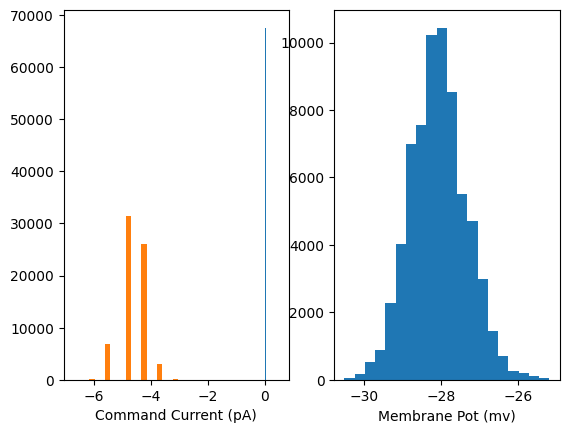

  1%|█                                                                                  | 1/83 [00:00<00:25,  3.16it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0004.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0005.abf
analysis failed


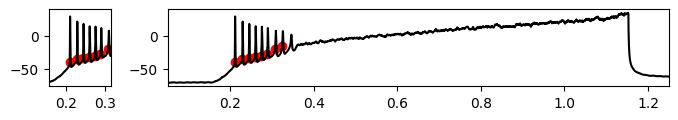

  5%|████                                                                               | 4/83 [00:00<00:13,  5.67it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0007.abf
analysis failed


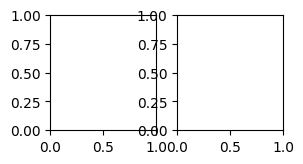

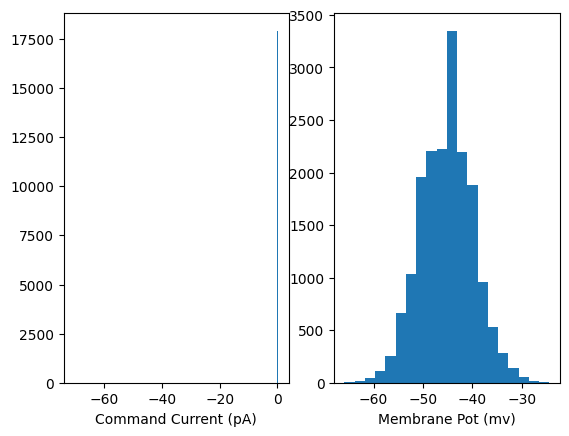

  7%|██████                                                                             | 6/83 [00:01<00:16,  4.76it/s]

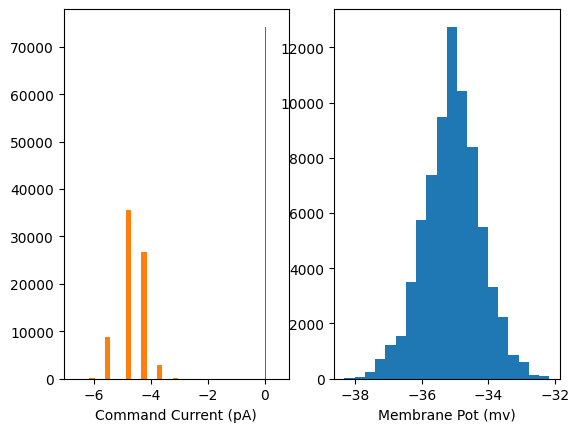

  8%|██████▉                                                                            | 7/83 [00:01<00:18,  4.20it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c002_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c002_DGC_0004.abf
analysis failed


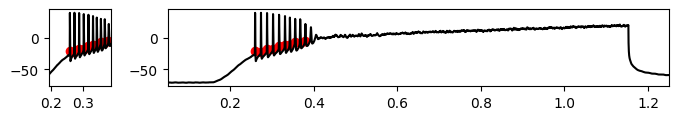

 12%|█████████▉                                                                        | 10/83 [00:01<00:13,  5.45it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s001_c002_DGC_0006.abf
analysis failed


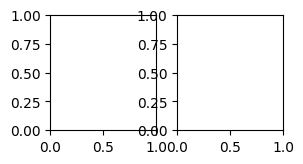

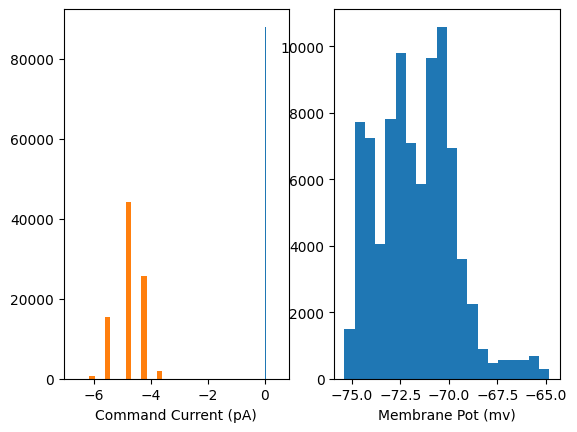

 14%|███████████▊                                                                      | 12/83 [00:02<00:14,  4.96it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s002_c003_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s002_c003_DGC_0004.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s002_c003_DGC_0005.abf
analysis failed


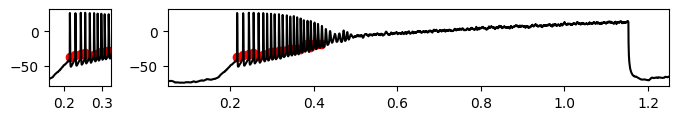

 19%|███████████████▊                                                                  | 16/83 [00:02<00:10,  6.70it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s002_c003_DGC_0007.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s002_c003_DGC_0009.abf
analysis failed


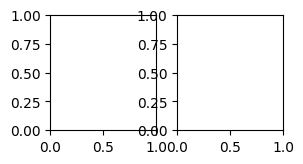

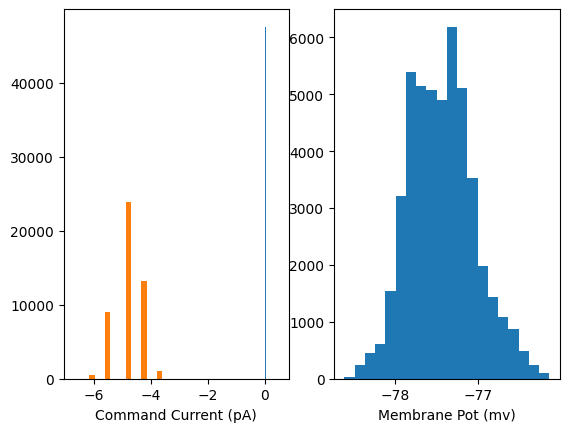

 23%|██████████████████▊                                                               | 19/83 [00:03<00:09,  6.63it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s003_c004_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s003_c004_DGC_0004.abf
analysis failed


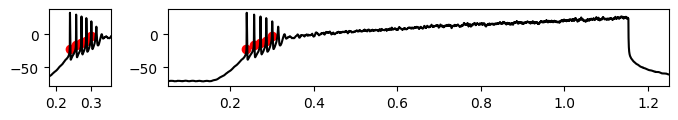

 27%|█████████████████████▋                                                            | 22/83 [00:03<00:09,  6.56it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s003_c004_DGC_0006.abf
analysis failed


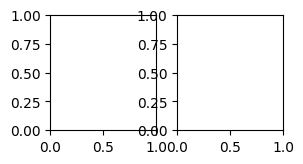

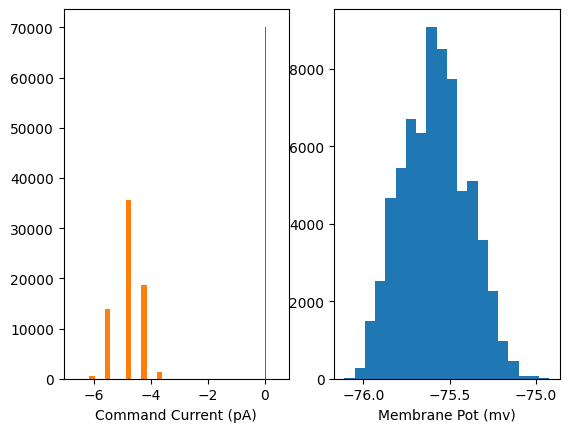

 29%|███████████████████████▋                                                          | 24/83 [00:04<00:10,  5.87it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s003_c005_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s003_c005_DGC_0004.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s003_c005_DGC_0005.abf
analysis failed


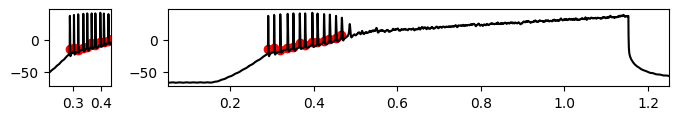

 34%|███████████████████████████▋                                                      | 28/83 [00:04<00:07,  7.16it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s003_c005_DGC_0007.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s003_c005_DGC_0008.abf
analysis failed


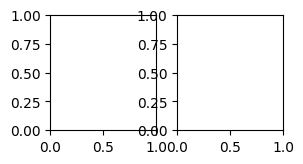

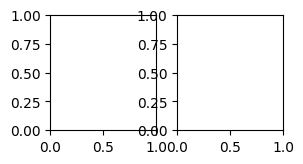

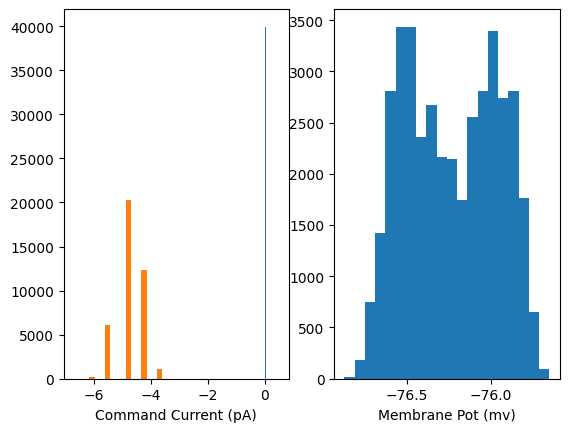

 37%|██████████████████████████████▋                                                   | 31/83 [00:05<00:08,  6.41it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s004_c006_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s004_c006_DGC_0004.abf
analysis failed


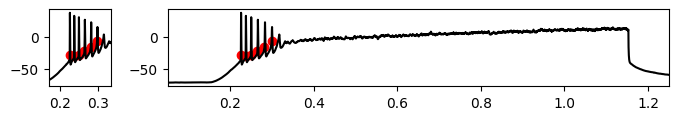

 41%|█████████████████████████████████▌                                                | 34/83 [00:05<00:07,  6.92it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s004_c006_DGC_0006.abf
analysis failed


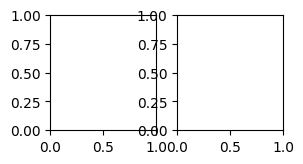

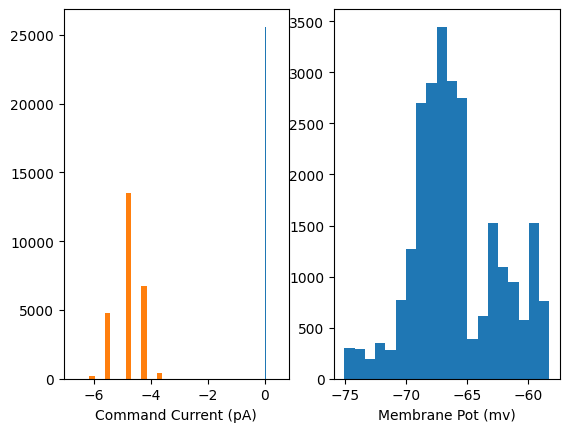

 43%|███████████████████████████████████▌                                              | 36/83 [00:05<00:07,  6.10it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s005_c007_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s005_c007_DGC_0004.abf
analysis failed


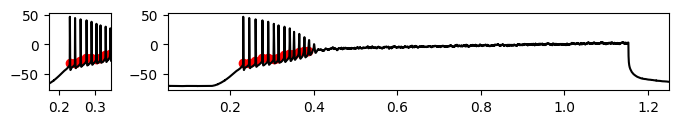

 47%|██████████████████████████████████████▌                                           | 39/83 [00:06<00:06,  6.65it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x24\2024x04x24_E3KI_F_P598_sagi_s005_c007_DGC_0006.abf
analysis failed


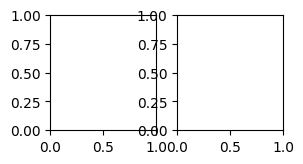

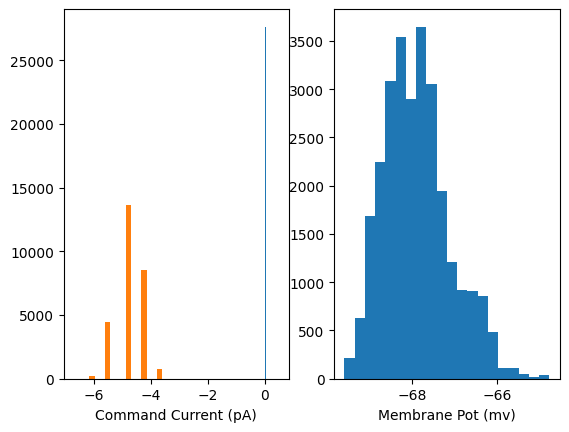

 49%|████████████████████████████████████████▌                                         | 41/83 [00:06<00:06,  6.02it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s001_c002_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s001_c002_DGC_0004.abf
analysis failed


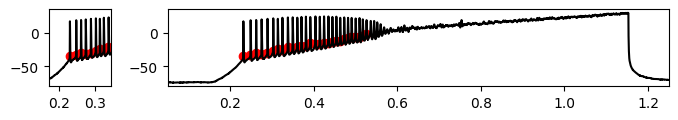

 53%|███████████████████████████████████████████▍                                      | 44/83 [00:07<00:06,  6.15it/s]

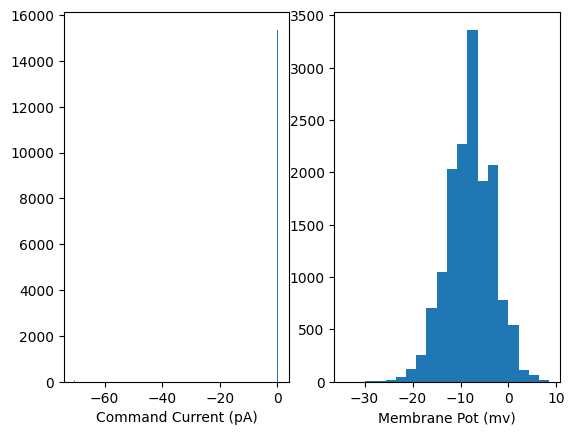

 55%|█████████████████████████████████████████████▍                                    | 46/83 [00:07<00:06,  5.63it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s001_c002_DGC_0009.abf
analysis failed


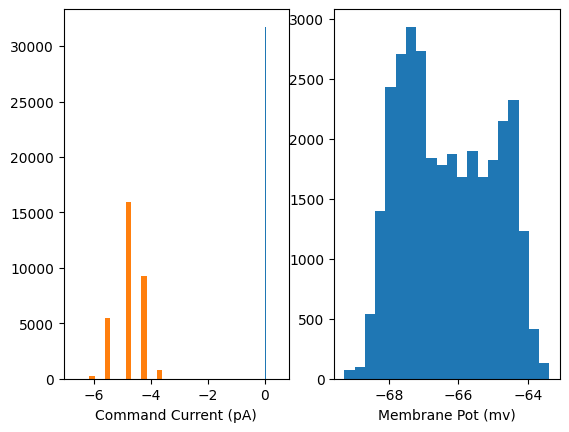

 58%|███████████████████████████████████████████████▍                                  | 48/83 [00:08<00:06,  5.78it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s001_c003_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s001_c003_DGC_0004.abf
analysis failed


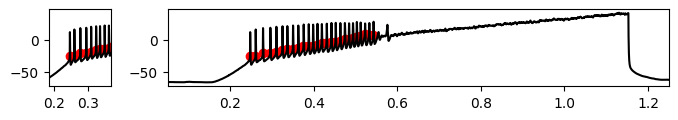

 61%|██████████████████████████████████████████████████▍                               | 51/83 [00:08<00:05,  6.36it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s001_c003_DGC_0006.abf
analysis failed


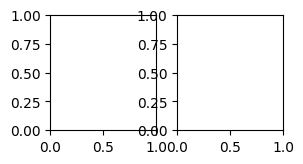

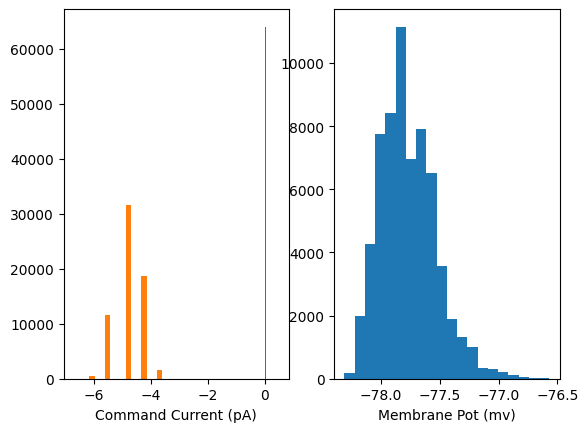

 65%|█████████████████████████████████████████████████████▎                            | 54/83 [00:08<00:04,  6.05it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s002_c004_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s002_c004_DGC_0004.abf
analysis failed


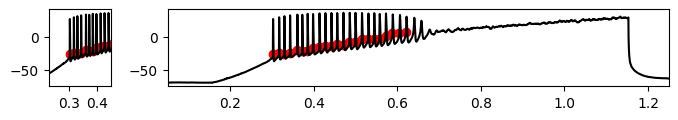

 69%|████████████████████████████████████████████████████████▎                         | 57/83 [00:09<00:03,  6.54it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s002_c004_DGC_0006.abf
analysis failed


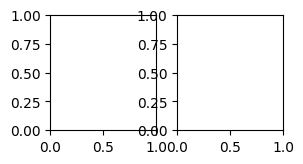

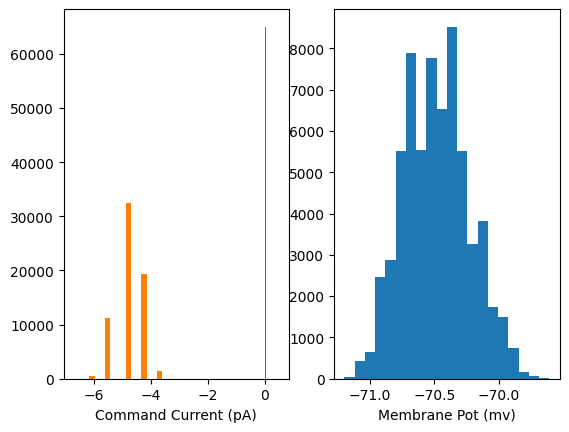

 71%|██████████████████████████████████████████████████████████▎                       | 59/83 [00:09<00:04,  5.84it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s003_c005_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s003_c005_DGC_0004.abf
analysis failed


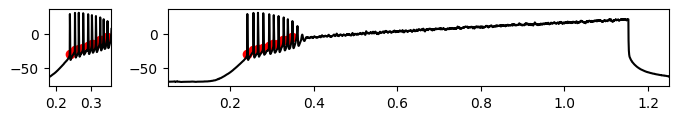

 75%|█████████████████████████████████████████████████████████████▎                    | 62/83 [00:10<00:03,  6.51it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s003_c005_DGC_0006.abf
analysis failed


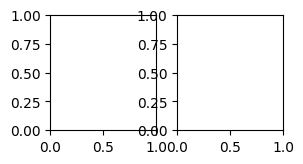

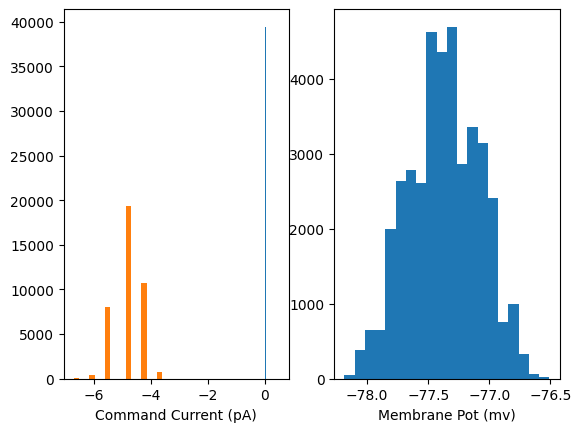

 77%|███████████████████████████████████████████████████████████████▏                  | 64/83 [00:10<00:03,  5.64it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s003_c006_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s003_c006_DGC_0004.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s003_c006_DGC_0005.abf
analysis failed


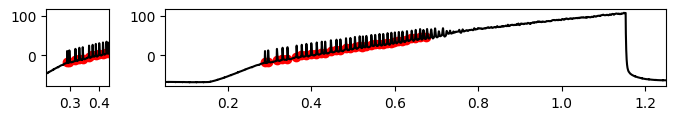

 82%|███████████████████████████████████████████████████████████████████▏              | 68/83 [00:11<00:02,  6.49it/s]

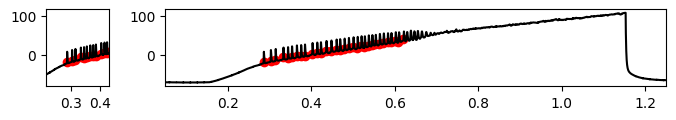

 83%|████████████████████████████████████████████████████████████████████▏             | 69/83 [00:11<00:02,  5.65it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s003_c006_DGC_0008.abf
analysis failed


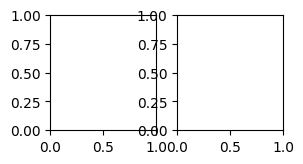

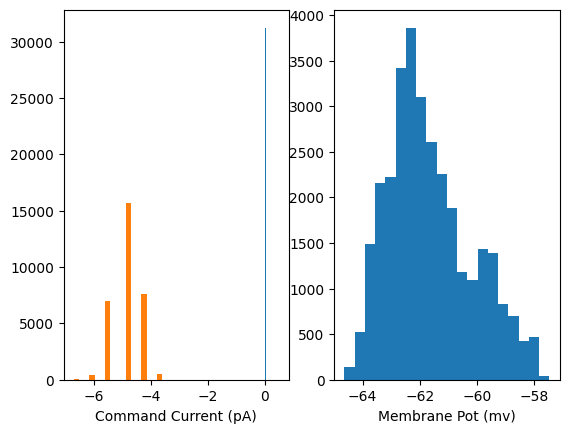

 86%|██████████████████████████████████████████████████████████████████████▏           | 71/83 [00:11<00:02,  5.14it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s004_c007_DGC_0004.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s004_c007_DGC_0005.abf
analysis failed


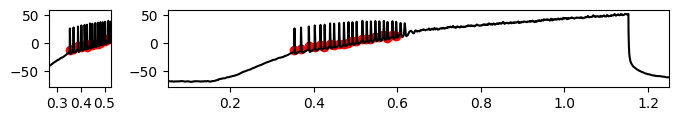

 90%|██████████████████████████████████████████████████████████████████████████        | 75/83 [00:12<00:01,  6.67it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P590_sagi_s004_c007_DGC_0007.abf
analysis failed


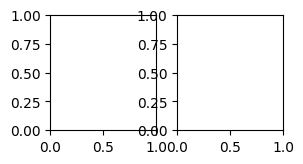

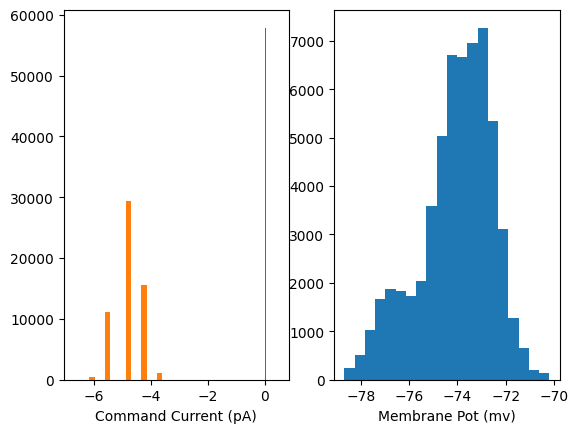

 93%|████████████████████████████████████████████████████████████████████████████      | 77/83 [00:12<00:01,  5.89it/s]


 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P599_sagi_s001_c001_DGC_0003.abf
analysis failed

 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P599_sagi_s001_c001_DGC_0004.abf
analysis failed


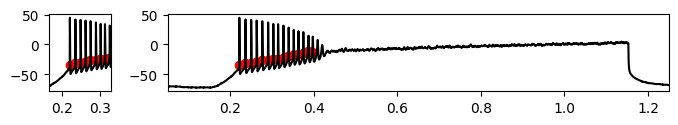

100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:13<00:00,  6.29it/s]



 error on:  C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\4_Methods\_Patch_Refactor\test_data\2024x04x25\2024x04x25_E3KI_F_P599_sagi_s001_c001_DGC_0006.abf
analysis failed
problem_recs


KeyError: 'Cmq_160.0'

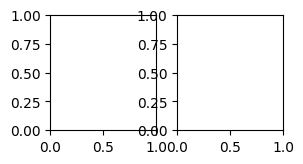

In [14]:

fast_results = ephys_wrapper_local(dataset,VC_prot,IC_prot,strat_cols=['Genotype','Age_Bin'])

In [ ]:
print(os.getcwd().replace('\\','/'))

C:/Users/dennis.tabuena/Desktop/Test_Folder/git_code


In [ ]:
# fast_results = substitute_gain_rheobase(fast_results,
#                                        strat_cols=['Genotype','Age_Bin','Cell_Type'],
#                                        age_bin_dict=age_bin_dict)


In [ ]:
f = fast_results

In [ ]:

single_val_strat_groups = ['ap_amplitutude',
                            'Rmp_mV',
                            'Cmq_160.0',
                            'Ra_160.0',
                            'Rm_160.0',
                            'Gain_(HzpA)',
                            'inact_current_pA',
                            'Rheobase',
                            'AP_thresh_US',
                            'fast_after_hyperpol',
                            'Spike_latency_(ms)',
                            'Input_Resistance_MO',
                            ]


manual_exclusions = ['']
exclusion_overide = ['']
file_naming_scheme = dataset['file_naming_scheme']
strat_df_dict = fast_results['strat_df_dict'].copy()
strat_df_dict = {k:strat_df_dict[k] for k in my_order}
filtered_dict, fail_dict = final_qc(strat_df_dict,file_naming_scheme,qc_Rmp=-35,qc_AP_amp=20,qc_RR=.20,qc_Ra=np.inf,manual_exclusions=manual_exclusions,exclusion_overide=exclusion_overide)
alt_strat_dict = restratify_results(filtered_dict,file_naming_scheme,single_val_strat_groups)

resp_curve_list = ['IV_Early_(V_stim)','IV_Early_(I_peak)','IV_Steady_State_(I_mean)','Stim_Levels_(pA)','Spike_Counts']
response_curve_data = stratify_response_curve(filtered_dict,resp_curve_list,strat_list=[''])
alt_strat_dict.update(response_curve_data)
write_strat_dfs_local(alt_strat_dict, dataset['data_name']+'_results_stratified_alternate')
print(os.getcwd())


NameError: name 'fast_results' is not defined

In [ ]:
feature_list = ['Cm_pc_10.0',
             'Cmq_160.0',
             'Input_Resistance_MO',
             'Rm_160.0',
             'Rmp_mV',
             'Gain_(HzpA)',
             'Spike_latency_(ms)',
             'Rheobase',
             'inact_current_pA',
             'ap_amplitutude',
             'fast_after_hyperpol',
             'sAHP',
             'AP_thresh_US',
             'ap50_width_ms']



In [ ]:
def generate_prism_csv(data_df,max_replicates=None):
    data_type = data_df.columns[0]

    # Step 1: Group data by 'Age_Bin' and 'Genotype' and collect values
    grouped = data_df.groupby(['Age_Bin', 'Genotype'])[data_type].apply(list).reset_index()

    # Step 2: Determine maximum number of replicates based on the size of groups
    if max_replicates is None:
        max_replicates = grouped[data_type].str.len().max()

    # Step 3: Prepare a DataFrame for the multi-level index
    results = []

    # Replicate numbering function (retained as per your request)
    def rep_num(i):
        if i == 0:
            return ""
        else:
            return f'{i + 1:03}'  # Returns '001', '002', etc.

    # Step 4: Generate all possible rows, padding with None where necessary
    for _, row in grouped.iterrows():
        age_bin = row['Age_Bin']
        geno_type = row['Genotype']
        values = row[data_type]

        # Ensure every group has max_replicates, padding missing values with None
        for i in range(max_replicates):
            if i < len(values):
                # If value exists, use it
                results.append({'Age_Bin': age_bin, 'Genotype': geno_type, 'Replicate': rep_num(i), 'Value': values[i]})
            else:
                # If no value, add a row with None
                results.append({'Age_Bin': age_bin, 'Genotype': geno_type, 'Replicate': rep_num(i), 'Value': None})

    # Step 5: Create a DataFrame from the results
    final_df = pd.DataFrame(results)

    # Step 6: Pivot the DataFrame to have Age_Bin as index and multi-level columns, ensuring all replicates exist
    pivot_df = final_df.pivot_table(index='Age_Bin', columns=['Genotype', 'Replicate'], values='Value', aggfunc='first')

    # Step 7: Ensure all replicate columns exist up to max_replicates, even if some are missing in the data
    all_replicates = [rep_num(i) for i in range(max_replicates)]
    pivot_df = pivot_df.reindex(columns=pd.MultiIndex.from_product([pivot_df.columns.levels[0], all_replicates]), fill_value=None)

    # Step 8: Reset index for easier display
    pivot_df.reset_index(inplace=True)

    return pivot_df, max_replicates



def flatten_multiindex(df):
    df.columns = [''.join(map(str, col)).strip() for col in df.columns.values]
    return df



232